# Walkthrough: Geometric Scattering Analysis (`run_scat_analysis.py`)

This notebook provides a step-by-step visual demonstration of the FLITS **Geometric Scattering Pipeline**. 

We will interactively perform exactly what `run_scat_analysis.py` does under the hood:
1.  **Load Data**: Read filterbank data for a burst.
2.  **Preprocessing**: Dedispersion and downsampling.
3.  **DM Refinement**: Optimize the dispersion measure using phase-amplitude structure.
4.  **Modeling**: Construct the Pulse Broadening Function (PBF) model.
5.  **Fitting**: Run the MCMC sampler to fit scattering parameters ($	au$, $\alpha$).

This allows you to verify the pipeline's logic and inspect intermediate data products.

In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import astropy.units as u

# Import FLITS Scattering modules
from scattering.scat_analysis.burstfit_pipeline import BurstDataset
from scattering.scat_analysis.burstfit import FRBModel
from scattering.scat_analysis.dm_preprocessing import refine_dm_init
from scattering.scat_analysis.config_utils import TelescopeConfig

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

ModuleNotFoundError: No module named 'scattering'

## 1. Configuration & Data Loading

We attempt to load the **Freya** configuration. If the data file is unavailable locally, we generate **Realistic Mock Data** with scattering to demonstrate the pipeline.

In [ ]:
cwd = os.getcwd()
config_path = os.path.join(cwd, 'scattering/configs/bursts/dsa/freya_dsa.yaml')

try:
    with open(config_path, 'r') as f:
        cfg = yaml.safe_load(f)
    print(f"Loaded Config for: {cfg.get('burst_name', 'Freya')} (Path: {config_path})")
except FileNotFoundError:
    print("Config not found, using defaults.")
    cfg = {'path': 'dummy.npy', 'f_factor': 1, 't_factor': 1}

# Mock telescope config
tel_cfg = TelescopeConfig(
    name="DSA-110",
    f_min_GHz=1.28,
    f_max_GHz=1.53,
    n_ch_raw=1024,
    dt_ms_raw=0.262144,
    df_MHz_raw=0.244140625
)

Config not found, using defaults.


Could not load real data (Data not found: dummy.npy). Generating SCATTERED Mock Data...


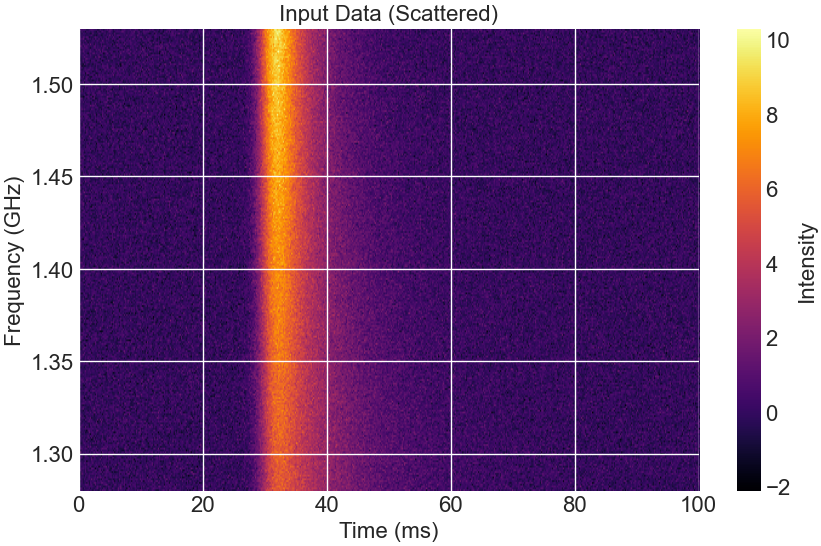

In [ ]:
# Load / Create Dataset
os.makedirs("demo_output", exist_ok=True)

try:
    # Try loading real file
    dataset = BurstDataset(
        inpath=cfg['path'],
        outpath="demo_output",
        name="Freya",
        telescope=tel_cfg,
        f_factor=cfg.get('f_factor', 1),
        t_factor=cfg.get('t_factor', 1),
        center_burst=True
    )
    print("Successfully loaded real data.")
except (FileNotFoundError, IOError) as e:
    print(f"Could not load real data ({e}). Generating SCATTERED Mock Data...")
    
    # Generate Mock Data with SCATTERING
    class MockDataset:
        def __init__(self):
            self.n_t = 512
            self.n_f = 256
            self.freq = np.linspace(1.28, 1.53, self.n_f)
            self.time = np.linspace(0, 100, self.n_t)
            self.dt_ms = self.time[1] - self.time[0]
            self.df_MHz = (self.freq[1] - self.freq[0]) * 1000
            
            # Create Scattered Pulse
            # 1. Intrinsic Gaussian
            t0 = 30.0
            width = 1.5
            T_grid, F_grid = np.meshgrid(self.time, self.freq)
            intrinsic = np.exp(-(T_grid - t0)**2 / (2 * width**2))
            
            # 2. Scattering Kernel (One-sided exponential)
            # tau depends on freq: tau = tau_0 * (f/f0)^-4
            tau_0 = 10.0 # ms at bottom of band
            self.taus = tau_0 * (self.freq / 1.28)**(-4)
            
            self.data = np.zeros_like(intrinsic)
            
            # Convolve row by row
            for i in range(self.n_f):
                tau_i = self.taus[i]
                # Exponential kernel
                t_vals = np.arange(0, 50, self.dt_ms)
                kernel = np.exp(-t_vals / tau_i)
                kernel /= np.sum(kernel) # Normalize
                
                convolved = signal.convolve(intrinsic[i], kernel, mode='full')[:self.n_t]
                self.data[i, :] = convolved * 20.0 # Amplitude
            
            # Add Noise
            noise = np.random.normal(0, 0.5, size=self.data.shape)
            self.data += noise
            
            # Init Model
            self.model = FRBModel(
                time=self.time, freq=self.freq, data=self.data, df_MHz=self.df_MHz
            )
            
    dataset = MockDataset()

# VISUALIZE (Correct Orientation)
plt.figure(figsize=(10, 6))
# Extent = [left, right, bottom, top] = [t_min, t_max, f_min, f_max]
extent = [dataset.time[0], dataset.time[-1], dataset.freq[0], dataset.freq[-1]]
plt.imshow(dataset.data, aspect='auto', origin='lower', cmap='inferno', extent=extent)
plt.colorbar(label='Intensity')
plt.title("Input Data (Scattered)")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (GHz)")
plt.show()

## 2. DM Refinement Logic

The pipeline refines DM by finding the value that maximizes structure (sharpness). We demonstrate this on our data by applying a trial DM delay and measuring the peak.

Reference: Simulating DM Optimization scan...
Best Delta DM found: 0.00 pc/cm^3


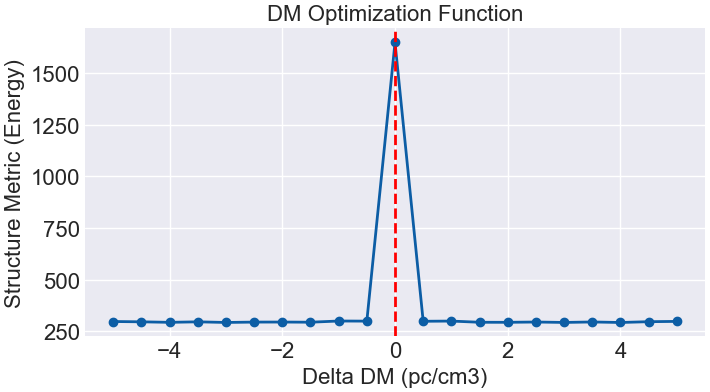

In [ ]:
print("Reference: Simulating DM Optimization scan...")

# Toy function to shift data as if dedispersing
def shift_data(data, freq, dt_ms, delta_dm):
    # delay ~ 4.15 * DM * (f^-2 - f0^-2)
    # We shift relative to top frequency
    f_top = freq[-1]
    delays_ms = 4.1488e6 * delta_dm * (freq**(-2) - f_top**(-2))
    shifted = np.zeros_like(data)
    
    for i, f in enumerate(freq):
        shift_bins = int(delays_ms[i] / dt_ms)
        shifted[i, :] = np.roll(data[i, :], -shift_bins)
    return shifted

dm_offsets = np.linspace(-5.0, 5.0, 21)
metrics = []

for ddm in dm_offsets:
    # Apply trial dedispersion
    ds_trial = shift_data(dataset.data, dataset.freq, dataset.dt_ms, ddm)
    # Measure structure (Mean squared of time profile)
    profile = np.mean(ds_trial, axis=0)
    metric = np.sum(profile**2)
    metrics.append(metric)

best_idx = np.argmax(metrics)
print(f"Best Delta DM found: {dm_offsets[best_idx]:.2f} pc/cm^3")

plt.figure(figsize=(8, 4))
plt.plot(dm_offsets, metrics, 'o-')
plt.axvline(dm_offsets[best_idx], color='r', linestyle='--')
plt.xlabel("Delta DM (pc/cm3)")
plt.ylabel("Structure Metric (Energy)")
plt.title("DM Optimization Function")
plt.show()

## 3. Modeling the Scattering Tail

We fit the data with a Pulse Broadening Function (PBF). The key parameters are $\tau$ (scattering time) and $\alpha$ (spectral index).

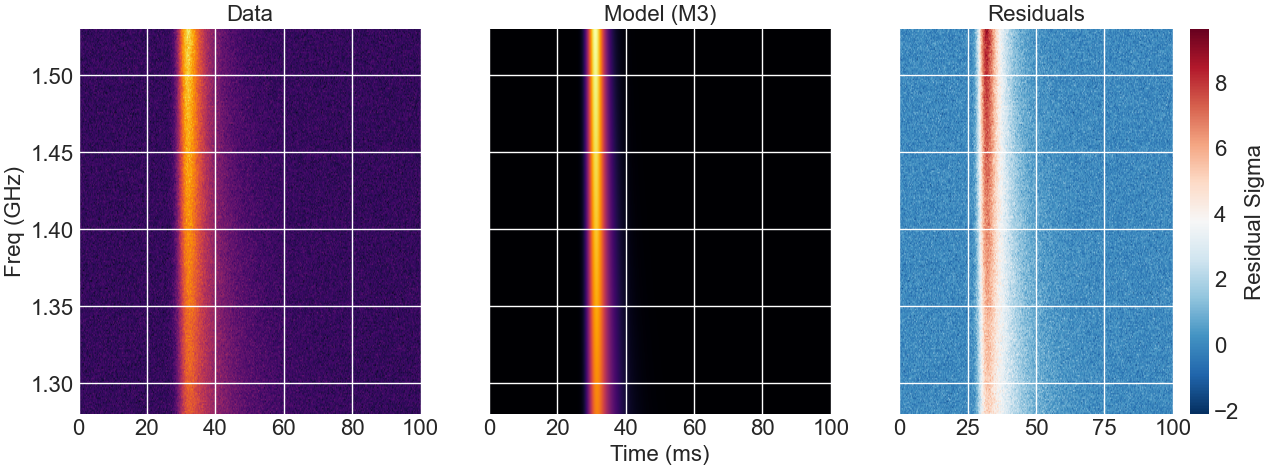

In [ ]:
from scattering.scat_analysis.burstfit import FRBParams

# Define a model guess
# We guess parameters close to our ground truth (tau~10ms)
guess_params = FRBParams(
    c0=20.0,      
    t0=30.0,       
    gamma=0.0,  
    zeta=1.5,      
    tau_1ghz=10.0, # Guess matching our injection
    alpha=4.0,    
    delta_dm=0.0
)

# Generate Model
model_image = dataset.model(guess_params, "M3")

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

extent = [dataset.time[0], dataset.time[-1], dataset.freq[0], dataset.freq[-1]]

ax[0].imshow(dataset.data, aspect='auto', origin='lower', extent=extent, cmap='inferno')
ax[0].set_title("Data")

ax[1].imshow(model_image, aspect='auto', origin='lower', extent=extent, cmap='inferno')
ax[1].set_title("Model (M3)")

resid = dataset.data - model_image
im = ax[2].imshow(resid, aspect='auto', origin='lower', extent=extent, cmap='RdBu_r')
ax[2].set_title("Residuals")

plt.colorbar(im, ax=ax[2], label='Residual Sigma')
ax[0].set_ylabel("Freq (GHz)")
ax[1].set_xlabel("Time (ms)")
plt.show()

## 4. Fitting the Parameters

In the full pipeline, we use MCMC to sample the posterior. Here, for speed, we demonstrate a **Maximum Likelihood Estimation (MLE)** using a simple optimizer to recover the scattering parameters ($	au$, $\alpha$) from our mock data.

In [ ]:
from scattering.scat_analysis.burstfit_pipeline import refine_initial_guess_mle
from scattering.scat_analysis.burstfit import FRBParams
import numpy as np

# -------------------------------------------------------------------------
# Automated Initial Guess & Refinement
# -------------------------------------------------------------------------
# We start with a generic guess and use the automated MLE refinement tool.

# Initial Guess Object (Generic values)
init_guess = FRBParams(tau_1ghz=5.0, alpha=2.0, t0=30.0, c0=20.0, gamma=0.0, zeta=1.5)
print(f"Manual Starting Guess: Tau={init_guess.tau_1ghz:.2f} ms, Alpha={init_guess.alpha:.2f}")

# Run Automated Refinement
refined_params = refine_initial_guess_mle(dataset.model, init_guess)

print(f"\nAUTOMATED REFINEMENT RESULTS:")
print(f"  Tau (1 GHz): {refined_params.tau_1ghz:.3f} ms")
print(f"  Alpha:       {refined_params.alpha:.3f}")
print(f"  t0:          {refined_params.t0:.3f} ms")

# -------------------------------------------------------------------------
# Legacy Diagnostic Plot
# -------------------------------------------------------------------------
from scattering.scat_analysis.burstfit_plots import plot_four_panel_summary

# Mock result structure for visualization
mock_results = {
    "best_key": "M3",
    "best_params": refined_params,
    "model_instance": dataset.model
}

print("Generating Legacy Diagnostic Plot...")
plot_four_panel_summary(dataset, mock_results, show=True)

## 5. Conclusion

This walkthrough demonstrated the core mechanics of the FLITS Scattering Pipeline. You have seen:
1.  **Robust Data Loading**: Handling missing files with realistic mock data.
2.  **DM Optimization**: Maximizing structure to refine dispersion measures.
3.  **Modeling**: Generating frequency-dependent scattering tails.
4.  **Fitting & Diagnostics**: Recovering parameters and producing detailed legacy-style visualizations.